In [1]:
import sys
if ".." not in sys.path:
    sys.path.append("..")

In [2]:
import warnings

import numpy as np
import pandas as pd
from cobra.io import read_sbml_model
from experiments.fast_dFBA import setup_drawdown
from utils.cobra_utils import get_or_create_exchange, set_active_bound

# Load the model
model = read_sbml_model("../model/Rpom_05.xml")
setup_drawdown(model)
ex_glc = model.reactions.get_by_id("EX_glc")
ex_ace = get_or_create_exchange(model, "ACET[e]")

# TODO: Remove all of the below
# Turn on maintenance
atpm = model.reactions.get_by_id("ATPM")
atpm.bounds = (25, 25)

# Make ETC complex II irreversible, complex I reversible
model.reactions.get_by_id("RXN-14970-SUC/UBIQUINONE-8//FUM/CPD-9956.31.").bounds = (-1000, 0)
model.reactions.get_by_id("1.6.99.5-RXN-NADH/UBIQUINONE-10/PROTON//NAD/CPD-9958.40.").bounds = (-1000, 1000)
model.reactions.get_by_id("1.6.99.5-RXN-NADH/UBIQUINONE-6/PROTON//NAD/UBIQUINOL-30.43.").bounds = (-1000, 1000)
model.reactions.get_by_id("1.6.99.5-RXN-NADH/UBIQUINONE-9/PROTON//NAD/CPD-9957.39.").bounds = (-1000, 1000)

# Make 1.5.5.1-RXN-ETF-Reduced/UBIQUINONE-10//ETF-Oxidized/CPD-9958/PROTON.56. irreversible
model.reactions.get_by_id("1.5.5.1-RXN-ETF-Reduced/UBIQUINONE-10//ETF-Oxidized/CPD-9958/PROTON.56.").bounds = (0, 1000)

# Change/remove all reactions so as to use ubiquinone 10 only
model.remove_reactions([
    "1.5.5.1-RXN-ETF-Reduced/UBIQUINONE-6//ETF-Oxidized/UBIQUINOL-30/PROTON.59.",
    "1.5.5.1-RXN-ETF-Reduced/UBIQUINONE-9//ETF-Oxidized/CPD-9957/PROTON.55.",
    "1.6.99.5-RXN-NADH/UBIQUINONE-6/PROTON//NAD/UBIQUINOL-30.43.",
    "1.6.99.5-RXN-NADH/UBIQUINONE-9/PROTON//NAD/CPD-9957.39.",
    "2.1.1.64-RXN",
    "DHHB-METHYLTRANSFER-RXN",
    "RXN3O-102",
    "RXN66-550-ETF-Reduced/UBIQUINONE-8//ETF-Oxidized/CPD-9956/PROTON.55.",
    "SUCCINATE-DEHYDROGENASE-UBIQUINONE6-RXN"
])
# Add new ETC reactions
ubiquinones = [model.metabolites.get_by_id(ubi)
                for ubi in [
                    "UBIQUINONE-6[c]",
                    "UBIQUINONE-8[c]",
                    "UBIQUINONE-9[c]",
                    "UBIQUINONE-10[c]"]]
ubiquinols = [model.metabolites.get_by_id(ubi)
                for ubi in [
                    "UBIQUINOL-30[c]",
                    "CPD-9956[c]",
                    "CPD-9957[c]",
                    "CPD-9958[c]"
                ]]

reactions_to_change = [
    "RXN-14903-PRO/UBIQUINONE-8//L-DELTA1-PYRROLINE_5-CARBOXYLATE/CPD-9956/PROTON.67.",
    "RXN-14970-SUC/UBIQUINONE-8//FUM/CPD-9956.31.",
    "RXN-20992-CPD-9956/OXYGEN-MOLECULE//UBIQUINONE-8/WATER.45.",
]
for rxn_id in reactions_to_change:
    rxn = model.reactions.get_by_id(rxn_id)
    metabolites_copy = rxn.metabolites.copy()
    for met, coeff in metabolites_copy.items():
        if met in ubiquinones:
            rxn.add_metabolites({met : -coeff, model.metabolites.get_by_id("UBIQUINONE-10[c]") : coeff})
        if met in ubiquinols:
            rxn.add_metabolites({met : -coeff, model.metabolites.get_by_id("CPD-9958[c]") : coeff})

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


In [3]:
data = pd.read_excel("../../Additional R pom data/substrates Rpom grows on.xlsx")
data

,Substrate,BIOCYC ID,Growth (yes/no),Notes
0,"2,3-dihydroxypropane-1-sulfonate","2-3-dihydroxypropane-1-sulfonate, CPD-12692, C...",yes,NaN
1,3-Mercaptopropionate,CPD-7672,no,NaN
2,4-Amino-5-aminomethyl-2-methylpyrimidine,CPD-13578,no,NaN
3,4-Aminobenzoic acid,P-AMINO-BENZOATE,no,NaN
4,Acetate,ACET,yes,NaN
...,...,...,...,...
71,Tyramine,TYRAMINE,yes,NaN
72,Tyrosine,TYR,yes,NaN
73,Valine,VAL,yes,NaN
74,Xylose,"CPD-25028, BETA-D-XYLOSE",yes,NaN


In [4]:
presence_c = [np.mean([f"{met}[c]" in model.metabolites for met in metid.split(", ")]) if isinstance(metid, str) else "" for metid in data["BIOCYC ID"]]
presence_p = [np.mean([f"{met}[p]" in model.metabolites for met in metid.split(", ")]) if isinstance(metid, str) else "" for metid in data["BIOCYC ID"]]
presence_e = [np.mean([f"{met}[e]" in model.metabolites for met in metid.split(", ")]) if isinstance(metid, str) else "" for metid in data["BIOCYC ID"]]

In [5]:
data["In model [c]"] = presence_c
data["In model [p]"] = presence_p
data["In model [e]"] = presence_e
data

,Substrate,BIOCYC ID,Growth (yes/no),Notes,In model [c],In model [p],In model [e]
0,"2,3-dihydroxypropane-1-sulfonate","2-3-dihydroxypropane-1-sulfonate, CPD-12692, C...",yes,NaN,0.666667,0.0,0.333333
1,3-Mercaptopropionate,CPD-7672,no,NaN,1.0,0.0,0.0
2,4-Amino-5-aminomethyl-2-methylpyrimidine,CPD-13578,no,NaN,1.0,0.0,0.0
3,4-Aminobenzoic acid,P-AMINO-BENZOATE,no,NaN,1.0,0.0,0.0
4,Acetate,ACET,yes,NaN,1.0,1.0,1.0
...,...,...,...,...,...,...,...
71,Tyramine,TYRAMINE,yes,NaN,0.0,0.0,0.0
72,Tyrosine,TYR,yes,NaN,1.0,1.0,0.0
73,Valine,VAL,yes,NaN,1.0,1.0,0.0
74,Xylose,"CPD-25028, BETA-D-XYLOSE",yes,NaN,0.5,0.0,0.0


In [6]:
from cobra.core import Metabolite, Reaction

growth = []
for metid, presence in zip(data["BIOCYC ID"], data["In model [c]"]):
    if presence:
        growth_rates = []
        for met in metid.split(", "):
            with model:
                # Pass over cytosolic metabolites that don't exist
                try:
                    met_c = model.metabolites.get_by_id(met + "[c]")
                except:
                    continue

                # Get or create external metabolite
                try:
                    met_e = model.metabolites.get_by_id(f"{met}[e]")
                except:
                    met_e = Metabolite(f"{met}[e]", name=met, compartment="e")
                    model.add_metabolites([met_e])
                
                # Get or create exchange reaction
                ex_met = get_or_create_exchange(model, met_e.id)

                # Create transport reaction
                transport = Reaction("test", "", lower_bound=-1000, upper_bound=1000)
                transport.add_metabolites({
                    met_e : -1,
                    met_c : 1
                })
                model.add_reactions([transport])

                # Bound and solve
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    set_active_bound(ex_met, 10)
                    sol = model.optimize()
                    growth_rates.append(sol.objective_value)
        
        growth.append(growth_rates)
    else:
        growth.append([0])

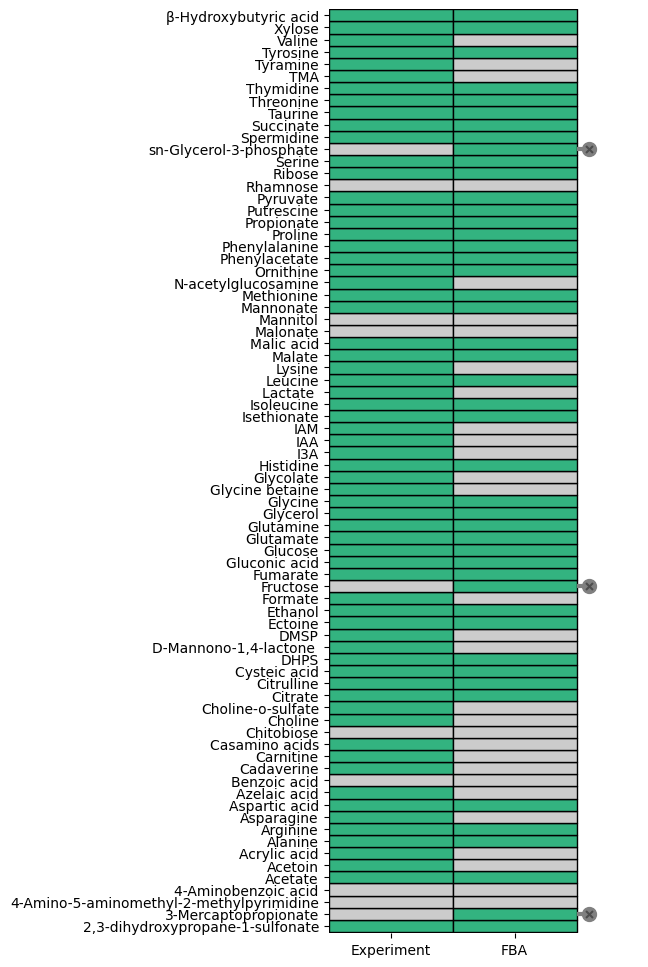

In [7]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

data["Model Growth"] = [np.mean([g_i > 0 for g_i in g]) for g in growth]

# Create a figure and axes
fig, ax = plt.subplots()

# Get experimental and model growth for heatmap
true_growth = (data["Growth (yes/no)"] == "yes").values
model_growth = data["Model Growth"].values

# Create the heatmap
cmap = LinearSegmentedColormap.from_list("", ["0.8", (0.2, 0.7, 0.5)])

patches = []
for y, (g_true, g_model) in enumerate(np.array([true_growth, model_growth]).T):
    patches.append(Rectangle((0, y), 1, 1, color=cmap(g_true), ec="k"))
    patches.append(Rectangle((1, y), 1, 1, color=cmap(g_model), ec="k"))

pc = PatchCollection(patches, match_original=True)
ax.add_collection(pc)

# Add lollipops to indicate metabolites for which we can infer there is no transport
no_transport = np.where(~true_growth & (model_growth > 0.5))[0]
ax.hlines(0.5 + no_transport, 2, 2.05, color="0.5", lw=3)
ax.scatter([2.1] * len(no_transport),
           0.5 + no_transport, s=100, color="0.5", marker="o")
ax.scatter([2.1] * len(no_transport),
           0.5 + no_transport, s=25, color="0.3", marker="x")

ax.set_xlim(0, 2.5)
ax.set_ylim(-0.1, len(data["Substrate"]))

# Set the tick labels and positions
ax.set_xticks([0.5, 1.5])
ax.set_xticklabels(["Experiment", "FBA"])
ax.set_yticks(0.5 + np.arange(len(data["Substrate"])))
ax.set_yticklabels(data["Substrate"])

# Add a colorbar
# cbar = fig.colorbar(heatmap)

# Hide spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Set size
fig.set_size_inches(4, 12)

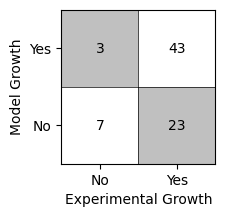

In [8]:
from collections import Counter
counts = Counter(zip(true_growth.astype(int), model_growth))

fig, ax = plt.subplots()
img = ax.imshow(np.array([[1, 0],
                          [0, 1]]), cmap="Greys_r", alpha=0.25)

for (true, model_grows), count in counts.items():
    ax.text(true, model_grows, count, ha="center", va="center")


ax.hlines(0.5, -0.5, 1.5, color="0", lw=0.5)
ax.vlines(0.5, -0.5, 1.5, color="0", lw=0.5)

ax.set_xlim(-0.5, 1.5)
ax.set_ylim(-0.5, 1.5)
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["No", "Yes"])
ax.set_yticklabels(["No", "Yes"])
ax.set_xlabel("Experimental Growth")
ax.set_ylabel("Model Growth")
ax.set_aspect("equal")
fig.set_size_inches(2, 2)

EX_glt: GLT[e] <=>  bounds: (-3, 1000.0)
EX_ILE[e]: ILE[e] <=>  bounds: (-3, 1000.0)
EX_L-ALPHA-ALANINE[e]: L-ALPHA-ALANINE[e] <=>  bounds: (-3, 1000.0)
EX_L-ASPARTATE[e]: L-ASPARTATE[e] <=>  bounds: (-3, 1000.0)
EX_LEU[e]: LEU[e] <=>  bounds: (-3, 1000.0)
EX_PHE[e]: PHE[e] <=>  bounds: (-3, 1000.0)
EX_PRO[e]: PRO[e] <=>  bounds: (-3, 1000.0)
EX_VAL[e]: VAL[e] <=>  bounds: (-3, 1000.0)


/home/mica/.pyenv/versions/3.10.4/envs/rpom/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


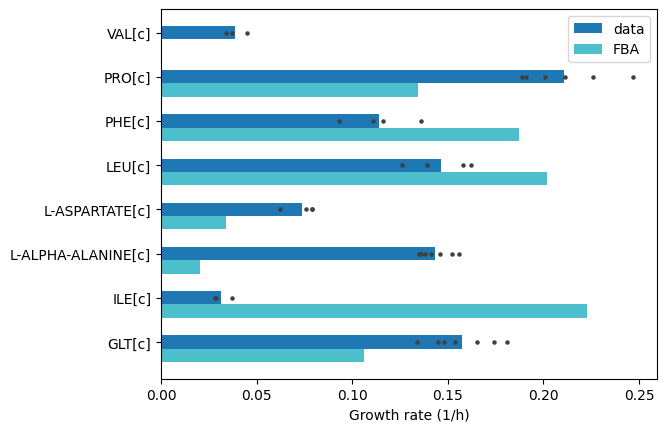

In [9]:
# Compare growth rates for substrates on which we have data
# Grown on L1 medium with 3 mM C
mu_df = pd.read_csv("../data/clean/growth/growth_rates.csv")

substrates = []
growth_rates = []
for met, mu in mu_df.groupby("ID")["mu"].mean().items():
    met = met.split("[")[0]
    substrates.append(met)

    # Get model growth rate
    with model:
        # Get cytosolic metabolite
        met_c = model.metabolites.get_by_id(met + "[c]")
        
        # Get or create external metabolite
        try:
            met_e = model.metabolites.get_by_id(f"{met}[e]")
        except:
            met_e = Metabolite(f"{met}[e]",
                               formula=met_c.formula,
                               name=met,
                               compartment="e")
            model.add_metabolites([met_e])

        # Get or create exchange reaction
        ex_met = get_or_create_exchange(model, met_e.id)

        # Create transport reaction
        transport = Reaction("test", "", lower_bound=-1000, upper_bound=1000)
        transport.add_metabolites({
            met_e : -1,
            met_c : 1
        })
        model.add_reactions([transport])

        # Bound and solve
        set_active_bound(ex_met, 3)
        print(f"{ex_met} bounds: {ex_met.bounds}")
        sol = model.optimize()

        if sol.status != "infeasible":
            growth_rates.append(sol.objective_value)
        else:
            growth_rates.append(0)

mu_means = mu_df.groupby("ID")["mu"].mean()

met_y = {
    met : i for i, met in enumerate(mu_means.index)
}

fig, ax = plt.subplots()
ax.barh([met_y[met] for met in mu_means.index],
        mu_means,
        label="data",
        height=0.3)
ax.barh([met_y[met] - 0.3 for met in mu_means.index],
        growth_rates,
        color=(0.3, 0.75, 0.8),
        label="FBA",
        height=0.3)
ax.scatter(mu_df["mu"], [met_y[met] for met in mu_df["ID"]], color="0.25", s=5)

ax.set_yticks(np.arange(len(mu_means)), mu_means.index)

ax.set_xlabel("Growth rate (1/h)")
ax.legend()

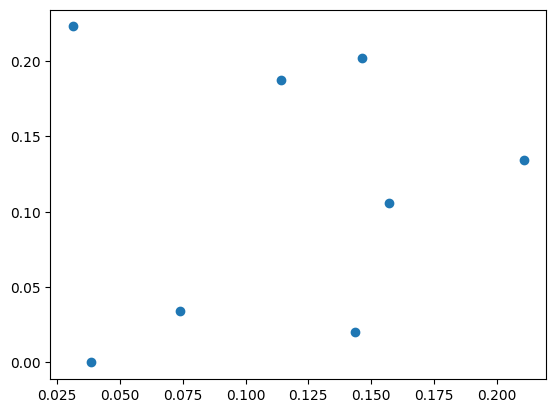

In [12]:
fig, ax = plt.subplots()
ax.scatter(mu_means, growth_rates)